### Goal: 
Use a GMM to put the birds into two groups, temperature when leaving where they migrate to, and temperature when leaving to go back home

In [1]:
import pandas as pd
import time
import pandas as pd
import requests
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

### Data Preprocessing 

In [2]:
migration_df = pd.read_csv('migrationTimingSiteUse_2008_2015/marbledGodwit_migration_ugashik_ruthrauff.csv')
migration_df.head(3)

,Sort_Order,Animal_ID,Year,Season,Departure_UTC,Arrival_UTC,Departure_Local,Arrival_Local,Flight_Duration_Hours,Stage,Overall_Duration_Days,Final_Destination,Departure_Site,Arrival_Site,Stay_Duration_Hours
0,1,MAGO_1A,2008,fall,8/7/2008 3:31,8/9/2008 14:53,8/6/2008 18:31,8/9/2008 6:53,59.36,S1,2.47,Y,ugashik,willapa,NaN
1,2,MAGO_2A,2008,fall,7/20/2008 2:17,7/22/2008 4:37,7/19/2008 17:17,7/21/2008 20:37,50.33,S1,2.10,Y,ugashik,bodega,6854.67
2,3,MAGO_2A,2009,spring,5/3/2009 19:17,5/6/2009 0:19,5/3/2009 11:17,5/5/2009 15:19,53.02,N1,NaN,N,bodega,controller,58.99


In [3]:
# Filter the dataframe to only store data if the flight stage is S1 or N1 (the bird is leaving)
filtered_migration_df = migration_df[(migration_df['Stage'] == 'S1') | (migration_df['Stage'] == 'N1')].loc[:, ['Departure_UTC', 'Departure_Site']].reset_index()
filtered_migration_df.head(3)

,index,Departure_UTC,Departure_Site
0,0,8/7/2008 3:31,ugashik
1,1,7/20/2008 2:17,ugashik
2,2,5/3/2009 19:17,bodega


In [4]:
# Get latitude and longitude of deperature sites
deperature_lat_lon = {
    'ugashik': (57.5577, 157.6269),
    'bodega': (38.3332, 23.0481),
    'humboldt': (40.7195, 124.2426), 
    'moss': (36.8058, 121.7902),
    'bolinas_ocean': (37.8965, 122.6786)
}

In [5]:
filtered_migration_df['Departure_Latitude'] = filtered_migration_df['Departure_Site'].map(lambda x: deperature_lat_lon[x][0])
filtered_migration_df['Departure_Longitude'] = filtered_migration_df['Departure_Site'].map(lambda x: deperature_lat_lon[x][1])
filtered_migration_df.head(3)

,index,Departure_UTC,Departure_Site,Departure_Latitude,Departure_Longitude
0,0,8/7/2008 3:31,ugashik,57.5577,157.6269
1,1,7/20/2008 2:17,ugashik,57.5577,157.6269
2,2,5/3/2009 19:17,bodega,38.3332,23.0481


In [6]:
filtered_migration_df['Departure_UTC'] = pd.to_datetime(filtered_migration_df['Departure_UTC'])
filtered_migration_df.head(3)

,index,Departure_UTC,Departure_Site,Departure_Latitude,Departure_Longitude
0,0,2008-08-07 03:31:00,ugashik,57.5577,157.6269
1,1,2008-07-20 02:17:00,ugashik,57.5577,157.6269
2,2,2009-05-03 19:17:00,bodega,38.3332,23.0481


API code from: https://rapidapi.com/meteostat/api/meteostat/

**dont run me anymore!!!**

In [7]:
# Function to get average temperature for a given location and date range
def get_temperature_data(lat, lon, start_date, end_date):
    url = "https://meteostat.p.rapidapi.com/point/daily"

    querystring = {
        "lat": lat,
        "lon": lon,
        "start": start_date,
        "end": end_date
    }

    headers = {
        'X-RapidAPI-Key': "dce607584dmsh5c8a13db16ffb10p1ada3djsnd4ed56a6987e",
        'X-RapidAPI-Host': "meteostat.p.rapidapi.com"
    }

    try: 
        response = requests.get(url, headers=headers, params=querystring)
        data = response.json()['data']
        return data
        # temperatures = [day['tmin'] for day in data if day['tmin'] is not None]
        
        # # Check one of the values was none
        # if temperatures: 
        #     min_temperature = min(temperatures)
        # else:
        #     return None
        
        # return average_temperature

    except Exception as e:
        print(f"Error: {e}")
        return None

In [14]:
# Get the temperature data
temp_data = []

# Iterate through each row 
for i, row in filtered_migration_df.iterrows():
    # Add row data
    lat = row['Departure_Latitude']
    lon = row['Departure_Longitude']
    start_time = (row['Departure_UTC'] - pd.Timedelta(days=10)).strftime('%Y-%m-%d')
    end_time = (row['Departure_UTC']).strftime('%Y-%m-%d')

    # Call API to get data up to -10 days away
    curr_temp_data = get_temperature_data(lat, lon, start_time, end_time)
    temp_data.append(curr_temp_data)

Error: 'data'
Error: 'data'
Error: 'data'
Error: 'data'
Error: 'data'
Error: 'data'


In [37]:
# Convert temp_data to a pandas data frame
all_data = []
csv_data = []

# Iterate through temp data
for group in temp_data:
    # Store feature data
    feature_data = []
    # Check if data exists
    if group:
        for day in group:
            csv_data.append(day)
            # Check if data exists (again)
            if day['tmin']:
                feature_data.append(day['tmin'])

    
        feature = sum(feature_data)/len(feature_data)
        all_data.append((day['date'], feature))

# Add 10 day average min to dataframe
temp_df = pd.DataFrame(all_data, columns = ['date', 'average_min'])
temp_df['month'] = pd.to_datetime(temp_df['date']).dt.month


# Convert to csv for safe keeping
df = pd.DataFrame(csv_data)
df.to_csv('temperature_data.csv', index=False)

/Users/bella/anaconda3/envs/adv_ds_ENV/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/bella/anaconda3/envs/adv_ds_ENV/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/bella/anaconda3/envs/adv_ds_ENV/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/bella/anaconda3/envs/adv_ds_ENV/lib/python3.12/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 varianc

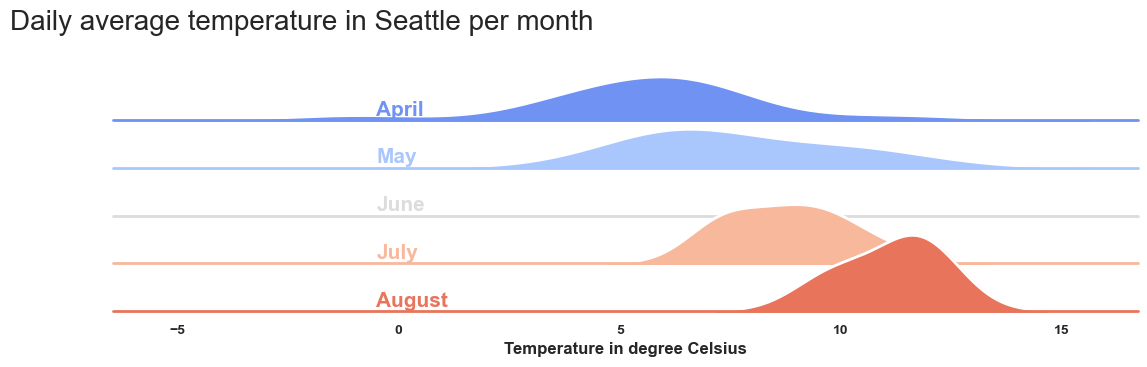

In [92]:
# Source: https://python-graph-gallery.com/ridgeline-graph-seaborn/
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
palette = sns.color_palette(palette='coolwarm', n_colors=5)

# Define dictionaries to make plot pretty
month_dict = {4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August'}

g = sns.FacetGrid(temp_df, row='month', aspect=15, height=0.75, palette=pal, hue='month')
g.map(sns.kdeplot, 'average_min', bw_adjust=1, clip_on=False, fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, 'average_min', bw_adjust=1, clip_on=False, color="w", lw=2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

for i, ax in enumerate(g.axes.flat):
    ax.text(-0.5, 0.02, month_dict[i+4], fontweight='bold', fontsize=15, color=ax.lines[-1].get_color())

# Adjust subplot spacing
g.fig.subplots_adjust(hspace=-0.4)

# Remove axes titles, yticks, and spines
g.set_titles("")
g.set(ylabel="")
g.set(yticks=[])
g.despine(bottom=True, left=True)


plt.setp(ax.get_xticklabels(), fontsize=10, fontweight='bold')
plt.xlabel('Min Temperature in Celsius', fontweight='bold', fontsize=12)
g.fig.suptitle('Daily average temperature in Seattle per month', ha='right', fontsize=20, fontweight=20)

plt.show()

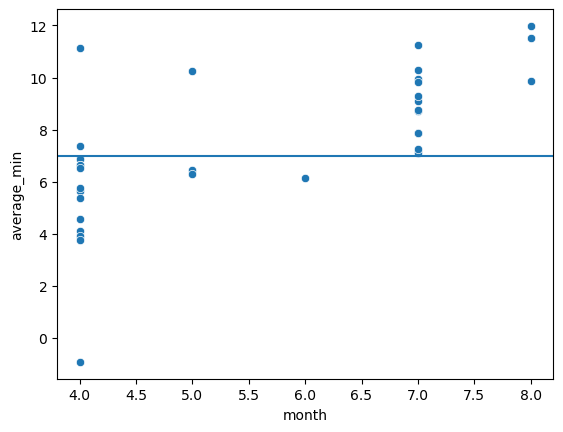

In [26]:
# Create the scatter plot
sns.scatterplot(x='month', y='average_min', data=temp_df)
plt.axhline(y = 7)

# Show the plot
plt.show()

In [ ]:
sns.kdeplot(x='average_min', data=df)

In [ ]:
# Iterate through all of the temperature data and choose features
min_temp_arr = []

for group in temp_data:
    group_min = []
    for day in group:
        group_min.append(day['tmax'] - day['tmin'])
    group_avg = sum(group_min)/ len(group_min)
    print(day['date'], group_avg)

In [ ]:
# Add the temperature data to the dataset
filtered_migration_df['Deperature_Weekly_Avg(C)'] = avg_weekly
filtered_migration_df.dropna(subset=['Deperature_Weekly_Avg(C)'], inplace=True)
filtered_migration_df

*done with data preprocessing don't run above anymore!*

### Applying the GMM

GMM code from Homework 4

In [ ]:
def GMM(df, k):
    dat = df.to_numpy()
    # Define variables
    covars = np.zeros(k)  # σ_m
    means = np.zeros(k)  # μ_m
    weights = np.zeros(k)  # w_m
    data_given_cluster = np.zeros((len(dat), k))  # P(x_i | cluster = m)

    # Initialize important variables
    init_idx = np.random.choice(range(len(dat)), size=k, replace=False)

    # Initialize σ_m, μ_m, and w_m for each k component (clusters)
    for dim in range(k):
        covars[dim] = np.var(dat)
        means[dim] = dat[init_idx[dim]]
        weights[dim] = 1 / k

    for _ in range(50):
        # Expectation step
        for i in range(len(dat)):
            for m in range(k):
                # Compute Φ(x_i | μ_m, σ_m)*w_m
                pdf = norm.pdf(dat[i], loc=means[m], scale=np.sqrt(covars[m]))
                data_given_cluster[i, m] = pdf * weights[m]
            # Normalize: pm_i = (pm_i)/(Σ_m pmi)
            data_given_cluster[i, :] /= np.sum(data_given_cluster[i, :])

        # Maximization step
        # Estimate weights: w_m = Σ pm_i / N
        weights = np.sum(data_given_cluster, axis=0) / len(dat)

        # Estimate μ_m, σ_m, w_m
        for m in range(k):
            # Estimate means: μ_m = (1/n_m)(Σ pm_i * x_i)
            weighted_sum = np.sum(data_given_cluster[:, m] * dat)
            total_p_m = np.sum(data_given_cluster[:, m])
            means[m] = weighted_sum / total_p_m

            # Estimate variance: σ_m = (1/n_m)(Σ pm_i * (x_i - μ_m)^2)
            diff = dat - means[m]
            reshaped_p_m = data_given_cluster[:, m].reshape(-1, 1)
            weighted_squared_diff = reshaped_p_m * diff ** 2
            covars[m] = np.sum(weighted_squared_diff) / np.sum(data_given_cluster[:, m])

            # Add small noise to variance to ensure positive definiteness
            covars[m] += 1e-6

    # Calculate the average distance to the cluster mean
    mean_dist = np.zeros(k)
    for m in range(k):
        weighted_squared_distance = np.sum(data_given_cluster[:, m] * (dat - means[m]) ** 2)
        mean_dist[m] = np.sqrt(weighted_squared_distance / len(dat))

    return data_given_cluster, means, covars, weights, mean_dist

In [ ]:
data = filtered_migration_df["Deperature_Weekly_Avg(C)"]
data

In [ ]:
# Find the best number of clusters
k_values = [1,2,3,4,5,6,7,8]
gmm_data = []

for k in k_values:
    data_given_cluster, means, covars, weights, mean_dist = GMM(data, k)
    gmm_data.append(np.mean(mean_dist))

plt.plot(k_values, gmm_data, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Weighted Mean Distance to Component')
plt.title('Elbow Plot')
plt.grid(True, alpha=0.4 )
plt.show()